## Testing for other dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

import joblib
import os

print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
subjects = [1] #for simpler decoding methods, only one subject is used

# Hold out last run (14) for testing
runs = [6, 10]  # motor imagery: hands vs feet 


# raw_fnames = eegbci.load_data(subject, runs)
# raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])

raws = []
for subject in subjects:
    raw_fnames = eegbci.load_data(subject, runs)
    raws += [read_raw_edf(f, preload=True) for f in raw_fnames]

raw = concatenate_raws(raws)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Automatically created module for IPython interactive environment
Extracting EDF parameters from /Users/nana/Documents/GitHub/eeg/data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/nana/Documents/GitHub/eeg/data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info struc

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

print(__doc__)

models_dir = '../models/'

# #############################################################################
# # Set parameters and read data


eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)
#raw.annotations.rename(dict(T1="hands", T2="feet"))


# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3)) #changed these two lines
event_id = dict(hands=2, feet=3)

#tmin, tmax applied here already
epochs = Epochs(
    raw,
    events = events, 
    event_id= event_id,
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

Automatically created module for IPython interactive environment
Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Using data from preloaded Raw for 30 events and 801 original time points ...
0 bad epochs dropped


Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


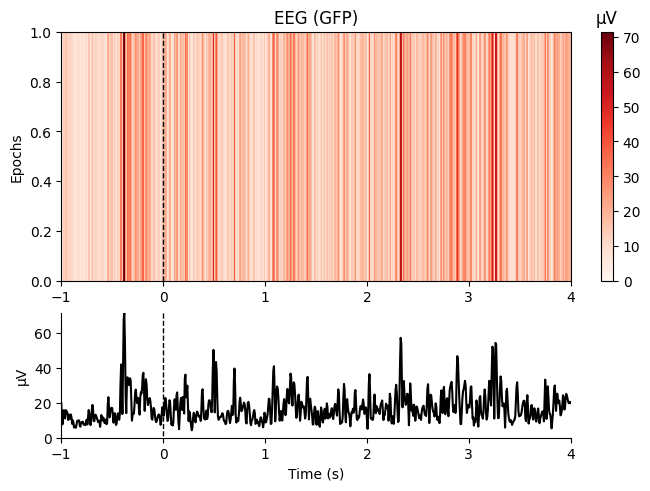

[<Figure size 640x480 with 3 Axes>]

In [3]:
epochs[0].plot_image()

Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 64 dim * 7.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Done.
Computing rank from data with rank=None
    Using tolerance 9.2e-05 (2.2e-16 eps * 64 dim * 6.5e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 pr

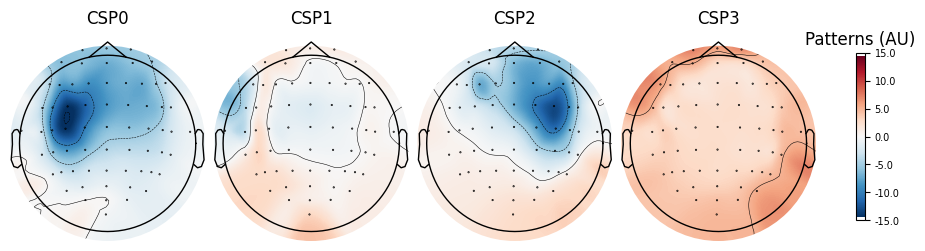

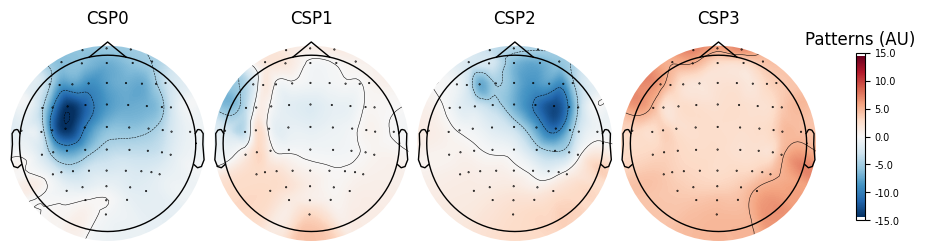

In [4]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data(copy=False)
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])

# Fit the pipeline to the training data
clf.fit(epochs_data_train, labels)

# Save the trained model
model_path = os.path.join(models_dir, 'csp_lda.pkl')
joblib.dump(clf, model_path)

scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)


# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

In [5]:
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

Classification accuracy: 0.9333333333333333 / Chance level: 0.5333333333333333


Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e-05 (2.2e-16 eps * 64 dim * 5.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 pro

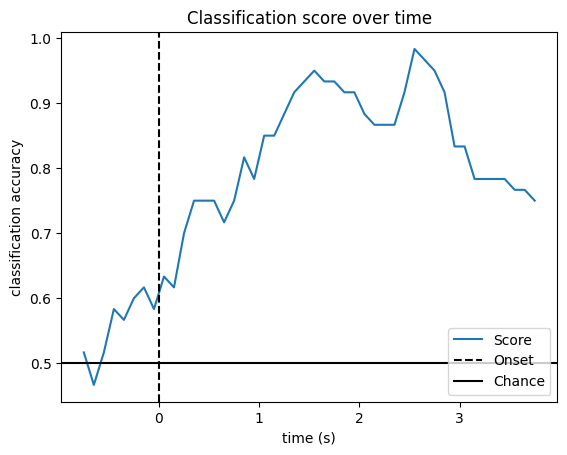

In [6]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [7]:
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [8]:
# cross validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
# get epochs
#epochs_data_train = 1e6 * epochs.get_data(copy=False) 

# compute covariance matrices
#cov_data_train = Covariances().transform(epochs_train)

In [9]:
# Assemble a classifier
lr = LogisticRegression()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)

clf = Pipeline([('CSP', csp), ('LogisticRegression', lr)])

# Fit the pipeline to the training data
clf.fit(epochs_data, labels)

# Save the trained model
model_path = os.path.join(models_dir, 'csp_logistic.pkl')
joblib.dump(clf, model_path)

scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("CSP + Logistic Regression Classification accuracy: %f / Chance level: %f" %
      (np.mean(scores), class_balance))

Computing rank from data with rank=None
    Using tolerance 0.00021 (2.2e-16 eps * 64 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector E

In [10]:
import pywt

def extract_wavelet_features(epochs, sampling_freq, wavelet='db4', num_levels=4):
    """
    Extract wavelet features from EEG epochs.

    Args:
        epochs (np.ndarray): 3D array of EEG epochs with shape (n_epochs, n_channels, n_samples)
        sampling_freq (float): Sampling frequency of the EEG data
        wavelet (str): Name of the wavelet family to use (default: 'db4')
        num_levels (int): Number of wavelet decomposition levels (default: 4)

    Returns:
        np.ndarray: 2D array of wavelet features with shape (n_epochs, n_features)
    """
    n_epochs, n_channels, n_samples = epochs.shape
    features = []

    for epoch in epochs:
        epoch_features = []
        for channel in epoch:
            # Perform wavelet decomposition
            coeffs = pywt.wavedec(channel, wavelet, level=num_levels)

            # Extract features from the detail coefficients
            channel_features = []
            for level in range(num_levels):
                detail_coeffs = coeffs[level]
                channel_features.extend([
                    np.mean(np.abs(detail_coeffs)),  # Mean of absolute values
                    np.std(detail_coeffs),  # Standard deviation
                    np.max(np.abs(detail_coeffs)),  # Maximum of absolute values
                ])

            epoch_features.append(channel_features)

        epoch_features = np.concatenate(epoch_features)
        features.append(epoch_features)

    features = np.array(features)
    return features

In [11]:
#svm classifier
from sklearn.svm import SVC

# import numpy as np
# from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#wavelet_features = extract_wavelet_features(epochs_data, sampling_freq=epochs.info['sfreq'])

# 2. Create a custom transformer class for wavelet feature extraction
from sklearn.base import BaseEstimator, TransformerMixin

class WaveletTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return extract_wavelet_features(X, sampling_freq=epochs.info['sfreq'])


wavelet_transformer = WaveletTransformer()
svm = SVC(kernel='rbf', gamma='auto', C=1.0)

clf = Pipeline([("Wavelet", wavelet_transformer), ("SVM", svm)])


# Fit the pipeline to the training data
clf.fit(epochs_data, labels)

# Save the trained model
model_path = os.path.join(models_dir, 'wavelet_svm.pkl')
joblib.dump(clf, model_path)

scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=1)

# Printing the results
# class_balance = np.mean(labels == labels[0])
# class_balance = max(class_balance, 1. - class_balance)
print("Wavelet + SVM Classification accuracy: %f / Chance level: %f" %
      (np.mean(scores), class_balance))


Wavelet + SVM Classification accuracy: 0.433333 / Chance level: 0.533333


In [12]:
# now try csp + svm
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)
svm = SVC(kernel='rbf', gamma='auto', C=1.0)
clf = Pipeline([('CSP', csp), ('SVM', svm)])

# Fit the pipeline to the training data
clf.fit(epochs_data, labels)

# Save the trained model
model_path = os.path.join(models_dir, 'csp_svm.pkl')
joblib.dump(clf, model_path)

scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=1)
print("CSP + SVM Classification accuracy: %f / Chance level: %f" %
        (np.mean(scores), class_balance))

Computing rank from data with rank=None
    Using tolerance 0.00021 (2.2e-16 eps * 64 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector E